# Introduction Forecasting with State Space Models (Unobserved Components)

## Prepare Notebook

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.gridspec as gridspec
import seaborn as sns
from statsmodels.tsa.statespace.structural import UnobservedComponents
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100

%reload_ext autoreload
%autoreload 2

## Generate Sample Data

In [2]:
min_date = pd.to_datetime('2017-01-01')
max_date = pd.to_datetime('2022-01-01')

data_df = pd.DataFrame(
    data={'date': pd.date_range(start=min_date, end=max_date, freq='W-MON')}
)

n = data_df.shape[0]


In [3]:
def generate_data(n, params, sigma_zeta=0.1, sigma_eta=0.1, sigma_epsilon=0.1):
    
    y = np.zeros(n)
    mu = np.zeros(n)
    beta = np.zeros(n)
    epsilon = np.zeros(n)
    eta = np.zeros(n)
    zeta = np.zeros(n)

    for t in range(1, n):
        
        zeta[t] = params['zeta'] * np.random.normal(loc=0.0, scale=sigma_zeta)
        beta[t] = params['beta_1'] * beta[t - 1] + zeta[t]
        
        eta[t] = params['eta'] * np.random.normal(loc=0.0, scale=sigma_eta)
        mu[t] = params['mu_1'] * mu[t -1] + params['beta_1'] * beta[t - 1] + eta[t]

        epsilon[t] = params['epsilon'] * np.random.normal(loc=0.0, scale=sigma_epsilon)
        y[t] = params['mu'] * mu[t] + epsilon[t]

    return y, mu, beta

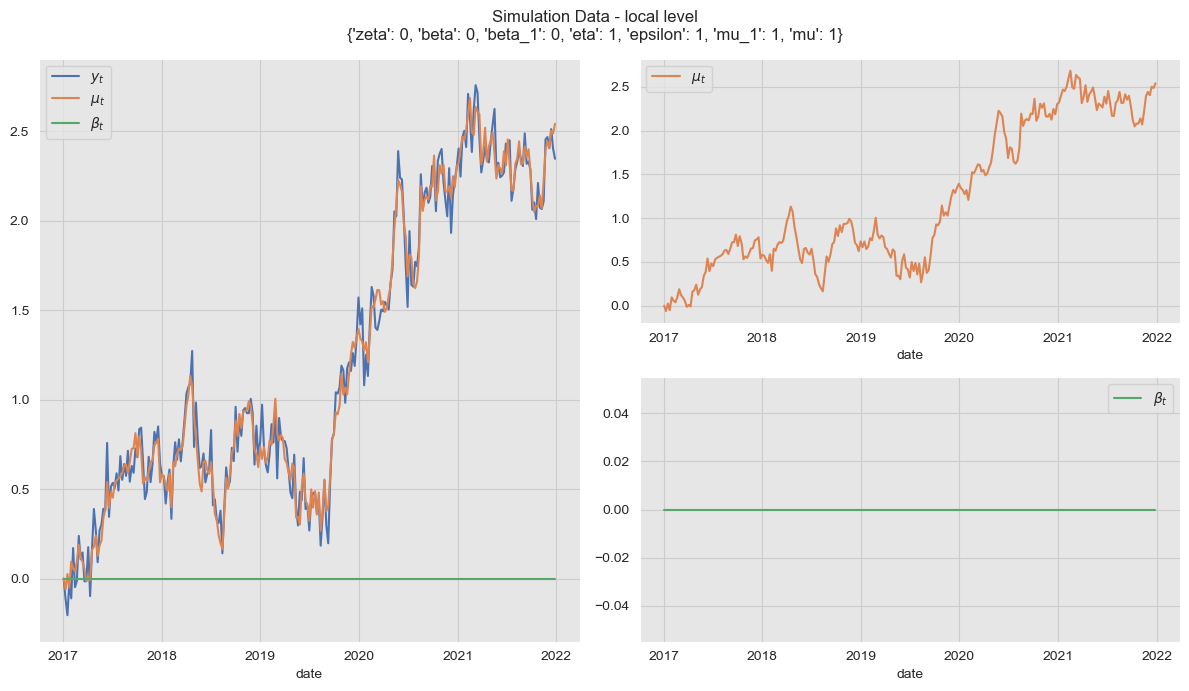

In [4]:
from mapping import PARAMS

np.random.seed(1)

model_names = list(PARAMS.keys())

model_name = model_names[2]
params = PARAMS.get(model_name, 'irregular')

y, mu, beta = generate_data(n=n, params=params)

fig = plt.figure(figsize=(12, 7), tight_layout=True)
gs = gridspec.GridSpec(2, 2)

ax = fig.add_subplot(gs[:, 0])
sns.lineplot(x=data_df['date'], y=y, color=sns_c[0], label=r'$y_t$', ax=ax)
sns.lineplot(x=data_df['date'], y=mu, color=sns_c[1], label=r'$\mu_t$', ax=ax)
sns.lineplot(x=data_df['date'], y=beta, color=sns_c[2], label=r'$\beta_t$', ax=ax)

ax0 = fig.add_subplot(gs[0, 1])
sns.lineplot(x=data_df['date'], y=mu, color=sns_c[1], label=r'$\mu_t$', ax=ax0)

ax1 = fig.add_subplot(gs[1, 1])
sns.lineplot(x=data_df['date'], y=beta, color=sns_c[2], label=r'$\beta_t$', ax=ax1)

fig.suptitle(f'Simulation Data - {model_name}\n{params}');

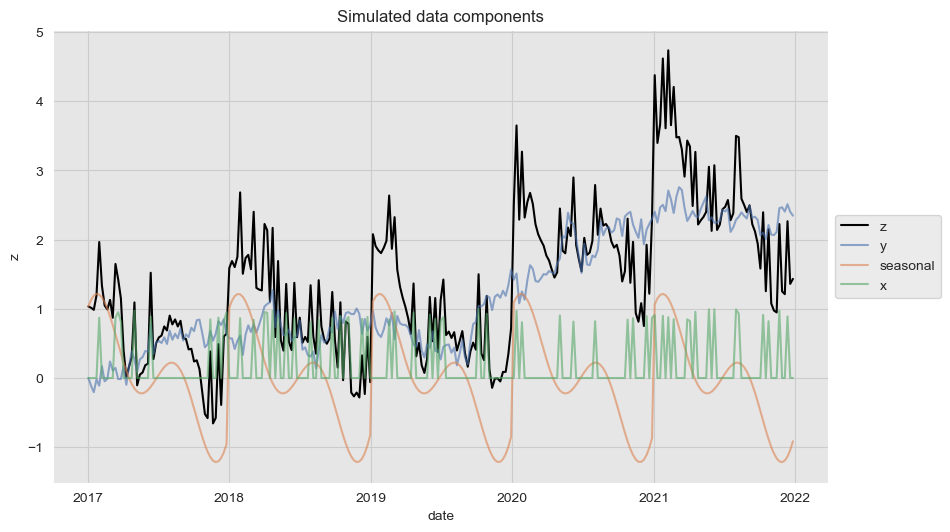

In [5]:
data_df['y'] = y

x = np.random.uniform(low=0.0, high=1.0, size=n)
data_df['x'] = np.where( x > 0.8, x, 0)

data_df['cs'] = np.sin(2 * np.pi * data_df['date'].dt.dayofyear / 356.5) 
data_df['cc'] = np.cos(3 * np.pi * data_df['date'].dt.dayofyear / 356.5) 
data_df['s'] = data_df['cs'] + data_df['cc']

data_df['z'] = data_df['y'] + data_df['x'] + data_df['s']

fig, ax = plt.subplots()
sns.lineplot(x='date', y='z', data=data_df, color='black', label='z', ax=ax)
sns.lineplot(x='date', y='y', data=data_df, color=sns_c[0], alpha=0.6, label='y', ax=ax)
sns.lineplot(x='date', y='s', data=data_df, color=sns_c[1], alpha=0.6, label='seasonal', ax=ax)
sns.lineplot(x='date', y='x', data=data_df, color=sns_c[2], alpha=0.6, label='x', ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Simulated data components');

In [6]:
data_df.set_index('date', inplace=True)
data_df.index = pd.DatetimeIndex(data_df.index.values, freq=data_df.index.inferred_freq)

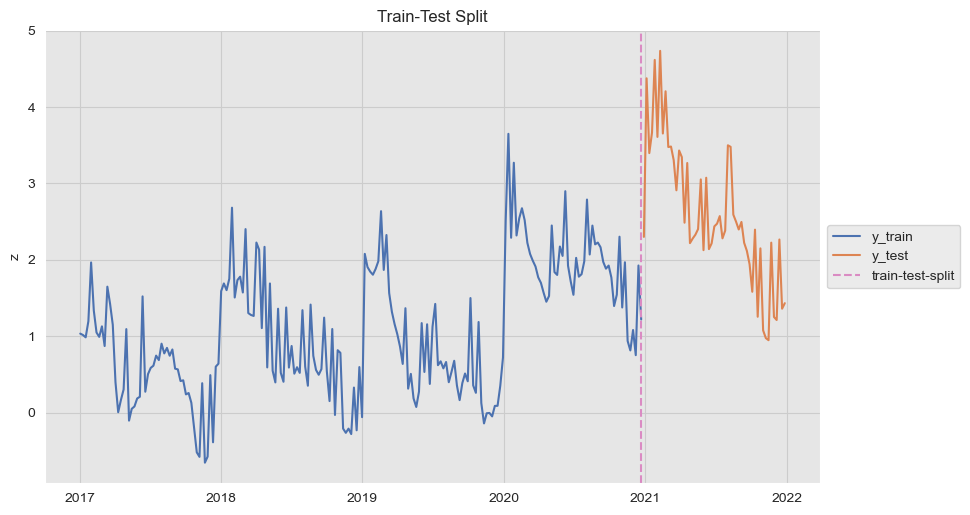

In [7]:
train_test_ratio = 0.80
n_train = int(n * train_test_ratio)
n_test = n - n_train

data_train_df = data_df[: n_train]
data_test_df = data_df[- n_test :]

y_train = data_train_df['z']
x_train = data_train_df[['x']]

y_test = data_test_df['z']
x_test = data_test_df[['x']]

fig, ax = plt.subplots()
sns.lineplot(x=y_train.index, y=y_train, color=sns_c[0], label='y_train', ax=ax)
sns.lineplot(x=y_test.index, y=y_test, color=sns_c[1], label='y_test', ax=ax)
ax.axvline(x=x_train.tail(1).index[0], color=sns_c[6], linestyle='--', label='train-test-split')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Train-Test Split');

## Model

In [8]:
model_params =  {
    'endog': y_train,
    'exog': x_train,
    'level': 'local level',
#     'freq_seasonal': [
#          {'period': 365, 'harmonics': 4}
#     ]
 }
 
model = UnobservedComponents(**model_params)

result = model.fit()

result.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.04812D-01    |proj g|=  8.95042D-01

At iterate    5    f=  2.17207D-01    |proj g|=  1.97129D-01

At iterate   10    f=  2.14171D-01    |proj g|=  2.67300D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     21      1     0     0   2.949D-06   2.142D-01
  F =  0.21417119640826204     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Unobserved Components Results                         
==============================================================================
Dep. Variable:                      z   No. Observations:                  208
Model:                    local level   Log Likelihood                 -44.548
Date:                Wed, 11 Aug 2021   AIC                             95.095
Time:                        22:53:16   BIC                            105.093
Sample:                    01-02-2017   HQIC                            99.138
                         - 12-21-2020                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular     0.0020      0.009      0.225      0.822      -0.015       0.019
sigma2.level         0.0861      0.016      5.505      0.000       0.055       0.117
beta.x               0.9870      0.045     22.157      0.000       0.900       1.074
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              5393.23
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                             3.88
Prob(H) (two-sided):                  0.96   Kurtosis:                        26.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

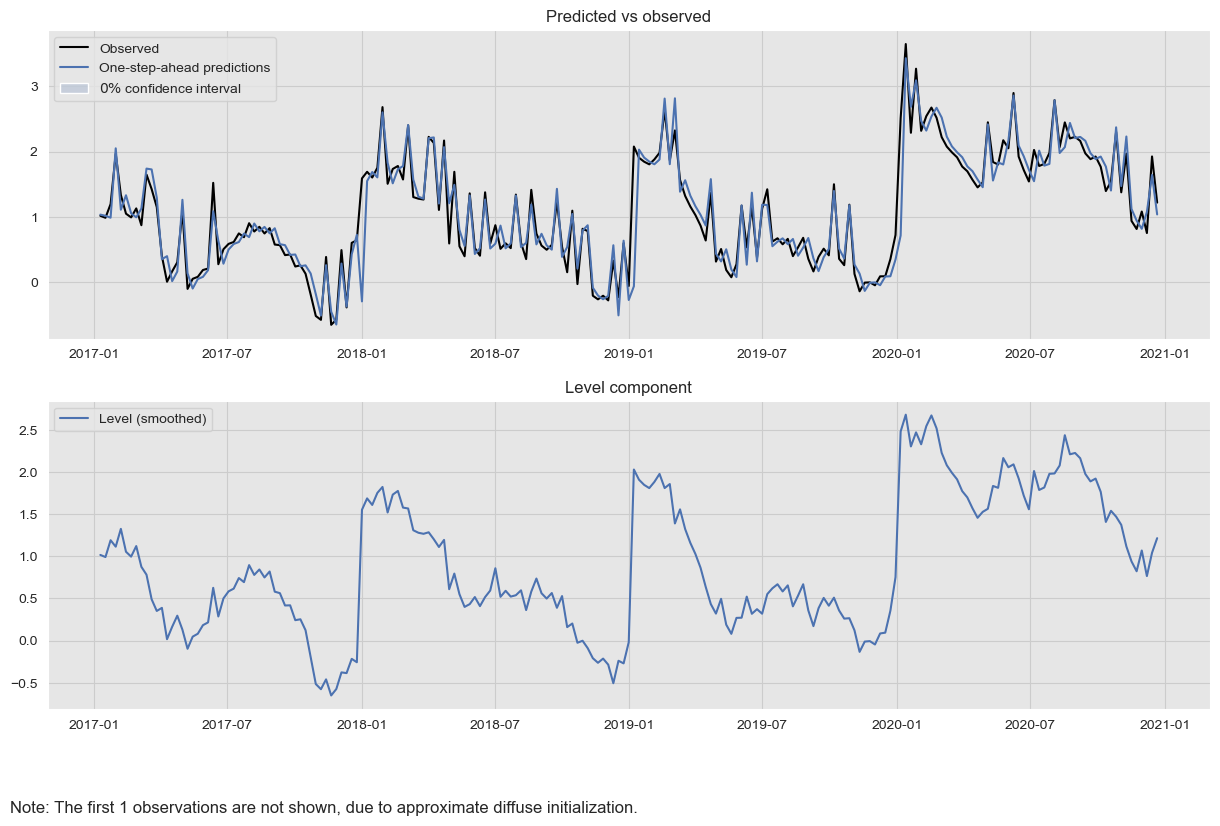

In [9]:
result.plot_components(
    alpha=1,
    figsize=(15, 9),
    legend_loc='upper left'
);

In [10]:
simulations_train_df = result.simulate(
    anchor='start',
    nsimulations=n_train,
    repetitions=1000,
    exog=x_train
)

simulations_test_df = result.simulate(
    anchor='end',
    nsimulations=n_test,
    repetitions=1000,
    exog=x_test
)

In [11]:
y_train_pred_mean = simulations_train_df.mean(axis=1)
y_train_pred_std = simulations_train_df.std(axis=1)
y_train_pred_plus = y_train_pred_mean + 2 * y_train_pred_std
y_train_pred_minus = y_train_pred_mean - 2 * y_train_pred_std

y_test_pred_mean = simulations_test_df.mean(axis=1)
y_test_pred_std = simulations_test_df.std(axis=1)
y_test_pred_plus = y_test_pred_mean + 2 * y_test_pred_std
y_test_pred_minus = y_test_pred_mean - 2 * y_test_pred_std

In [12]:
predictions_df = result \
    .get_prediction(steps=n_train, exog=x_train) \
    .summary_frame(alpha=0.95)

forecast_df = result \
    .get_forecast(steps=n_test, exog=x_test) \
    .summary_frame(alpha=0.95)

predictions_df.iloc[0] = 0

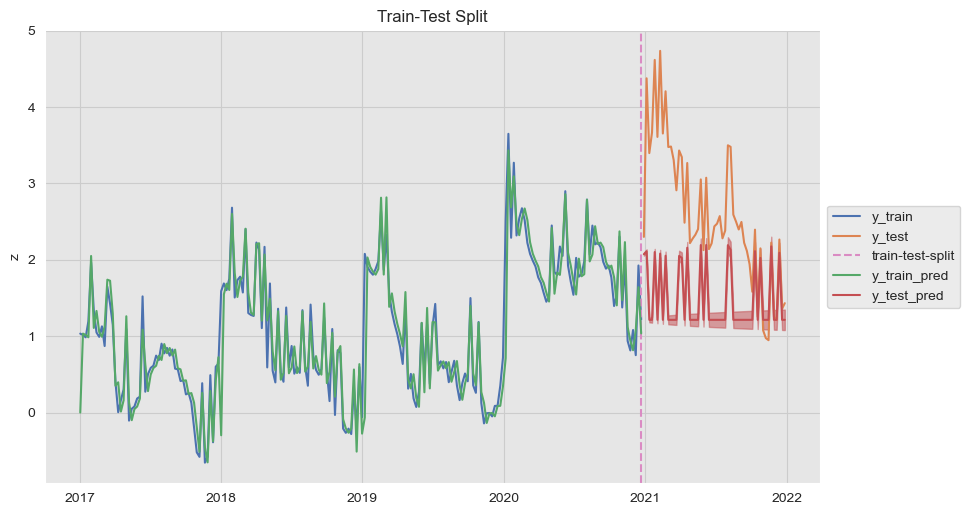

In [13]:
fig, ax = plt.subplots()

sns.lineplot(x=y_train.index, y=y_train, color=sns_c[0], label='y_train', ax=ax)
sns.lineplot(x=y_test.index, y=y_test, color=sns_c[1], label='y_test', ax=ax)
ax.axvline(x=x_train.tail(1).index[0], color=sns_c[6], linestyle='--', label='train-test-split')

# ax.fill_between(
#     x=y_train.index,
#     y1=predictions_df['mean_ci_lower'],
#     y2=predictions_df['mean_ci_upper'],
#     color=sns_c[2],
#     alpha=0.5
# )

ax.fill_between(
    x=y_test.index,
    y1=forecast_df['mean_ci_lower'],
    y2=forecast_df['mean_ci_upper'],
    color=sns_c[3],
    alpha=0.5
)

sns.lineplot(x=y_train.index, y=predictions_df['mean'], color=sns_c[2], label='y_train_pred', ax=ax)
sns.lineplot(x=y_test.index, y=forecast_df['mean'], color=sns_c[3], label='y_test_pred', ax=ax)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Train-Test Split');